In [3]:
#Imported Necessery Library

import torch
import pandas as pd
import numpy as np
import transformers
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
print(transformers.__version__)
print(torch.__version__)

4.11.3
1.9.1+cpu


In [5]:
# Read data
final = pd.read_csv("Dataset/E-Commerce.csv")
final.head()

,Review Text,sentiment
0,Absolutely wonderful - silky and sexy and comf...,2
1,Love this dress! it's sooo pretty. i happene...,2
2,I had such high hopes for this dress and reall...,1
3,"I love, love, love this jumpsuit. it's fun, fl...",2
4,This shirt is very flattering to all due to th...,2


In [6]:
#Define X and y
X=list(final['Review Text'])
y=list(final['sentiment'])

In [7]:
#split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [8]:
print(len(X_train))
print(len(X_test))

350
88


In [34]:
#deffine the confussion matrix

def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='micro')
    precision = precision_score(y_true=labels, y_pred=pred, average='micro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='micro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

## XLNet

In [37]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification

tokenizer_x = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model_x = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',num_labels=3)

loading file https://huggingface.co/xlnet-base-cased/resolve/main/spiece.model from cache at C:\Users\M1075352/.cache\huggingface\transformers\df73bc9f8d13bf2ea4dab95624895e45a550a0f0a825e41fc25440bf367ee3c8.d93497120e3a865e2970f26abdf7bf375896f97fde8b874b70909592a6c785c9
loading file https://huggingface.co/xlnet-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/xlnet-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/xlnet-base-cased/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingface.co/xlnet-base-cased/resolve/main/tokenizer.json from cache at C:\Users\M1075352/.cache\huggingface\transformers\46f47734f3dcaef7e236b9a3e887f27814e18836a8db7e6a49148000058a1a54.2a683f915238b4f560dab0c724066cf0a7de9a851e96b0fb3a1e7f0881552f53
loading configuration file https://huggingface.co/xlnet-base-cased/resolve/main/config.json from cache at C:\Users\M1075352/.cache\hu

In [38]:
train_enc = tokenizer_x(X_train, padding=True, truncation=True, max_length=512)
test_enc = tokenizer_x(X_test, padding=True, truncation=True, max_length=512)

In [43]:
# let’s turn our labels and encodings into a Dataset object for Training and test purpose 

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_d = Dataset(train_enc, y_train)
test_d = Dataset(test_enc, y_test)

In [44]:
##set the training arguments for traning 

training_args = TrainingArguments(
    output_dir='./results_x',
    evaluation_strategy="steps",
    num_train_epochs=4,             
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=16,  
    warmup_steps=100,                
    weight_decay=0.01,              
    logging_dir='./logs',          
    logging_steps=10,
    load_best_model_at_end=True
)

using `logging_steps` to initialize `eval_steps` to 10
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [45]:
#training 

trainer_x = Trainer(
    model=model_x,                         
    args=training_args,                 
    train_dataset=train_d,       
    eval_dataset=test_d,
    compute_metrics=compute_metrics
)

trainer_x.train()

***** Running training *****
  Num examples = 350
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 176


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,1.087400,1.090721,0.375000,0.375000,0.375000,0.375000
20,1.189600,1.102081,0.375000,0.375000,0.375000,0.375000
30,1.080600,1.080992,0.375000,0.375000,0.375000,0.375000
40,1.069000,1.072175,0.454545,0.454545,0.454545,0.454545
50,1.082500,1.135205,0.329545,0.329545,0.329545,0.329545
60,1.085600,1.049600,0.431818,0.431818,0.431818,0.431818
70,1.038800,1.034556,0.409091,0.409091,0.409091,0.409091
80,1.088300,1.058840,0.465909,0.465909,0.465909,0.465909
90,1.005000,0.893332,0.545455,0.545455,0.545455,0.545455
100,1.018600,0.888303,0.534091,0.534091,0.534091,0.534091


***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results_x\checkpoint-10
Configuration saved in ./results_x\checkpoint-10\config.json
Model weights saved in ./results_x\checkpoint-10\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results_x\checkpoint-20
Configuration saved in ./results_x\checkpoint-20\config.json
Model weights saved in ./results_x\checkpoint-20\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results_x\checkpoint-30
Configuration saved in ./results_x\checkpoint-30\config.json
Model weights saved in ./results_x\checkpoint-30\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results_x\checkpoint-40
Configuration saved in ./results_x\checkpoint-40\config.json
Model weights saved in ./results_x\checkpoint-40\pytorch_model.bin


TrainOutput(global_step=176, training_loss=0.9434558437629179, metrics={'train_runtime': 4122.483, 'train_samples_per_second': 0.34, 'train_steps_per_second': 0.043, 'total_flos': 126194107788000.0, 'train_loss': 0.9434558437629179, 'epoch': 4.0})

In [46]:
trainer_x.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 88
  Batch size = 16


{'eval_loss': 1.109796404838562,
 'eval_accuracy': 0.3522727272727273,
 'eval_precision': 0.3522727272727273,
 'eval_recall': 0.3522727272727273,
 'eval_f1': 0.3522727272727273,
 'eval_runtime': 53.3791,
 'eval_samples_per_second': 1.649,
 'eval_steps_per_second': 0.112,
 'epoch': 4.0}

In [47]:
# #predict
Pred_x = trainer_x.predict(test_dataset)


***** Running Prediction *****
  Num examples = 88
  Batch size = 16


In [48]:
trainer_x.predict(test_dataset)[1].shape

***** Running Prediction *****
  Num examples = 88
  Batch size = 16


(88,)

In [49]:
output_x=trainer_x.predict(test_dataset)[1]

***** Running Prediction *****
  Num examples = 88
  Batch size = 16


In [50]:
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(y_test,output_x)
matrix

array([[29,  0,  0],
       [ 0, 35,  0],
       [ 0,  0, 24]], dtype=int64)

In [52]:
#save the DistilBert model
trainer_x.save_model("./Model/xlnet_model")

Saving model checkpoint to ./Model/xlnet_model
Configuration saved in ./Model/xlnet_model\config.json
Model weights saved in ./Model/xlnet_model\pytorch_model.bin


### DistilBert

In [23]:
#Preprocessing
#called the pretrained model (distilbert) for tokenization
# from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification,Trainer,TrainingArguments
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

In [26]:
#Example 
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks annoyingly'

In [27]:
encodings = tokenizer(sample_txt, padding="max_length", truncation=True)

In [28]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks annoyingly
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', 'annoying', '##ly']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 15703, 2135]


In [29]:
#applying tokenizer for training and test dataset (DistilBertTokenizerFast)

train_encodings = tokenizer(X_train, padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(X_test, padding=True, truncation=True, max_length=512)

In [30]:
# let’s turn our labels and encodings into a Dataset object for Training and test purpose 

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

In [31]:
test_dataset

In [15]:
##set the training arguments for traning 

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    num_train_epochs=3,             
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=16,  
    warmup_steps=100,                
    weight_decay=0.01,              
    logging_dir='./logs',          
    logging_steps=10,
    load_best_model_at_end=True
)

In [16]:
#training 

trainer_db = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,       
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer_db.train()

***** Running training *****
  Num examples = 350
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 132


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,1.074600,1.086075,0.397727,0.397727,0.397727,0.397727
20,1.109800,1.085278,0.409091,0.409091,0.409091,0.409091
30,1.083100,1.080906,0.397727,0.397727,0.397727,0.397727
40,1.109900,1.076791,0.397727,0.397727,0.397727,0.397727
50,1.076200,1.074121,0.488636,0.488636,0.488636,0.488636
60,1.045700,1.042554,0.556818,0.556818,0.556818,0.556818
70,1.052500,0.980007,0.477273,0.477273,0.477273,0.477273
80,0.909600,0.865011,0.659091,0.659091,0.659091,0.659091
90,0.932900,1.028448,0.431818,0.431818,0.431818,0.431818
100,0.909500,0.906280,0.500000,0.500000,0.500000,0.500000


***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results\checkpoint-10
Configuration saved in ./results\checkpoint-10\config.json
Model weights saved in ./results\checkpoint-10\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results\checkpoint-20
Configuration saved in ./results\checkpoint-20\config.json
Model weights saved in ./results\checkpoint-20\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results\checkpoint-30
Configuration saved in ./results\checkpoint-30\config.json
Model weights saved in ./results\checkpoint-30\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results\checkpoint-40
Configuration saved in ./results\checkpoint-40\config.json
Model weights saved in ./results\checkpoint-40\pytorch_model.bin
***** Running Evaluation

TrainOutput(global_step=132, training_loss=0.9354518715179327, metrics={'train_runtime': 1651.1017, 'train_samples_per_second': 0.636, 'train_steps_per_second': 0.08, 'total_flos': 38848309800300.0, 'train_loss': 0.9354518715179327, 'epoch': 3.0})

In [17]:
trainer_db.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 88
  Batch size = 16


{'eval_loss': 0.7762371301651001,
 'eval_accuracy': 0.6590909090909091,
 'eval_precision': 0.6590909090909091,
 'eval_recall': 0.6590909090909091,
 'eval_f1': 0.6590909090909091,
 'eval_runtime': 18.7084,
 'eval_samples_per_second': 4.704,
 'eval_steps_per_second': 0.321,
 'epoch': 3.0}

In [22]:
# #predict
Pred = trainer_db.predict(test_dataset)

#pred, _, _ = trainer_db.predict(test_dataset)

***** Running Prediction *****
  Num examples = 88
  Batch size = 16


In [23]:
Pred[0]

array([[ 0.92078507,  0.80241716, -1.7717776 ],
       [ 0.68479824,  1.0178638 , -1.8449914 ],
       [ 0.52653664,  0.9653432 , -1.7092462 ],
       [ 0.44136798,  0.87729305, -1.5850458 ],
       [-1.5448184 , -0.0819838 ,  1.2862345 ],
       [-1.3953059 , -0.21782114,  1.3653089 ],
       [-0.596812  ,  0.51643634, -0.16759175],
       [ 0.41798395,  0.728462  , -1.4674158 ],
       [ 0.9537357 ,  0.7360021 , -1.9359077 ],
       [ 0.7145629 ,  0.86994165, -1.8050945 ],
       [ 1.3134803 ,  0.5125864 , -1.8324342 ],
       [-0.94383097,  0.550618  ,  0.12206863],
       [ 0.9015233 ,  0.8154589 , -1.827915  ],
       [ 1.182108  ,  0.63631487, -1.8833137 ],
       [ 0.8483616 ,  0.54114324, -1.5356498 ],
       [ 0.660493  ,  0.528335  , -1.3744648 ],
       [-1.489425  , -0.56670237,  1.8562918 ],
       [ 0.69607425,  0.9580624 , -1.8039017 ],
       [ 1.2227893 ,  0.52679586, -1.8078969 ],
       [-1.4898564 , -0.6129006 ,  1.8789382 ],
       [ 0.24912927,  0.70297253, -1.240

In [25]:
trainer_db.predict(test_dataset)[1].shape

***** Running Prediction *****
  Num examples = 88
  Batch size = 16


(88,)

In [27]:
output=trainer_db.predict(test_dataset)[1]

***** Running Prediction *****
  Num examples = 88
  Batch size = 16


In [28]:
output

array([0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0,
       1, 1, 2, 1, 0, 1, 0, 0, 0, 2, 2, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0,
       2, 0, 0, 0, 1, 2, 2, 1, 0, 2, 2, 0, 1, 1, 2, 1, 0, 2, 0, 1, 1, 1,
       2, 1, 2, 1, 2, 0, 2, 0, 0, 1, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1, 2, 0],
      dtype=int64)

In [29]:
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(y_test,output)
matrix

array([[29,  0,  0],
       [ 0, 35,  0],
       [ 0,  0, 24]], dtype=int64)

In [35]:
# #Classification report
# metrics.classification_report(y_test, output)

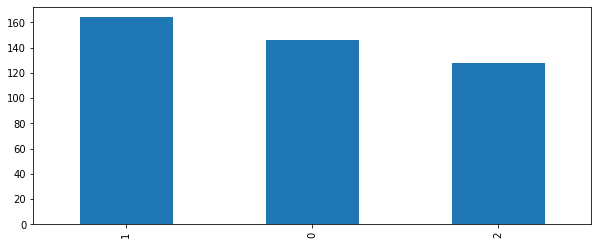

In [33]:
from matplotlib import pyplot as plt
lev = {0:'Negative', 1:'Neutral', 2:'Positive'}
plt.figure(figsize=(10,4))
final.sentiment.value_counts().plot(kind='bar');

In [45]:
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(output, y_test))

accuracy 1.0


In [47]:
#Creating dataframe for test data predictions

dict1 = {"text":X_test, "actual_label": y_test, "Pred_label":output}
df_pred = pd.DataFrame(dict1)
df_pred.head(5)

,text,actual_label,Pred_label
0,I love maeve and was so excited for this top w...,0,0
1,I ordered this in the orange color from online...,1,1
2,"Well, this top just did not do anything for me...",1,1
3,"The fabric is beautiful, even the lining is lo...",1,1
4,Nice top. armholes are a bit oversized but as ...,2,2


In [50]:
#Save the prediciton
df_pred.to_csv("Dataset/Prediction/test_pred_DistilBert.csv")

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

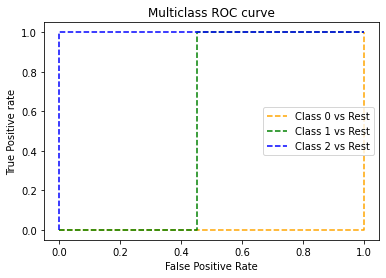

In [52]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, output, pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

### Inference from new data

In [53]:
new = pd.read_csv("Dataset/Rawdata.csv")
new.head()

,Review Text,Rating
0,This is a cute top that can transition easily ...,4
1,I absolutely love this bib tee! it's probably ...,5
2,Very soft and comfortable. the shirt has an un...,5
3,Nice top. armholes are a bit oversized but as ...,4
4,This is an adorable top that i find to be extr...,5


In [54]:
print(new.shape)

(267, 2)


In [55]:
##Encode 1 star and 2 star as Negative rated 0.
##Encode 3 star as neutral rated 1.
##Encode 4 star and 5 star as positive rated 2.

def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [56]:
#Applying the cindition to Rating Columns and created a new sentiment Column

new['sentiment'] = new.Rating.apply(to_sentiment)

In [57]:
#Checking the null values
print(new.isna().sum())


Review Text    4
Rating         0
sentiment      0
dtype: int64


In [58]:
new = new.dropna()

In [59]:
new_ = new.drop(["Rating"],axis=1)
new_.head()

,Review Text,sentiment
0,This is a cute top that can transition easily ...,2
1,I absolutely love this bib tee! it's probably ...,2
2,Very soft and comfortable. the shirt has an un...,2
3,Nice top. armholes are a bit oversized but as ...,2
4,This is an adorable top that i find to be extr...,2


### Single row inferences

In [61]:
# Create torch dataset with level
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        #print(item)
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])            
        return item
        
    def __len__(self):
        return len(self.encodings["input_ids"])

In [62]:
test_1 = list(new["Review Text"][:1])

#tokenized
test_1_tokenized = tokenizer(test_1, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset_new_ = Dataset(test_1_tokenized)

# Make prediction
raw_pred_, _, _ = trainer_db.predict(test_dataset_new_)

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


In [63]:
test_1

["This is a cute top that can transition easily from summer to fall. it fits well, nice print and it's comfortable. i tried this on in the store, but did not purchase it because the color washed me out. this is not the best color for a blonde. would look much better on a brunette. if this was in a different color i most likely would have purchased it."]

In [64]:
lev = {0:'Negative', 1:'Neutral', 2:'Positive'}

In [65]:
# Preprocess raw predictions
y_pred = np.argmax(raw_pred_, axis=1)

In [66]:
print(test_1)
print(y_pred)

["This is a cute top that can transition easily from summer to fall. it fits well, nice print and it's comfortable. i tried this on in the store, but did not purchase it because the color washed me out. this is not the best color for a blonde. would look much better on a brunette. if this was in a different color i most likely would have purchased it."]
[2]


### dateset for inference

In [67]:
#Preprocess the test data

test_all = list(new["Review Text"])
X_test_tokenized = tokenizer(test_all, padding=True, truncation=True, max_length=512)

In [68]:
len(test_all)

263

In [69]:
# Create torch dataset
test_dataset_new = Dataset(X_test_tokenized )

In [70]:
# Make prediction
new_raw_pred, _, _ = trainer_db.predict(test_dataset_new)

***** Running Prediction *****
  Num examples = 263
  Batch size = 16


In [71]:
# Preprocess raw predictions
y_pred_ = np.argmax(new_raw_pred, axis=1)

In [72]:
y_pred_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1,
       2, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
      dtype=int64)

In [73]:
#Creating dataframe for test data predictions

dict2 = {"Review Text":new["Review Text"], "sentiment":y_pred_ }
df_pred_new = pd.DataFrame(dict2)
df_pred_new.head(5)

,Review Text,sentiment
0,This is a cute top that can transition easily ...,2
1,I absolutely love this bib tee! it's probably ...,2
2,Very soft and comfortable. the shirt has an un...,2
3,Nice top. armholes are a bit oversized but as ...,2
4,This is an adorable top that i find to be extr...,2


In [74]:
#save new data inferences
df_pred_new.to_csv("Dataset/new_test_pred.csv")

### Save the model for future predection

In [75]:
#save the DistilBert model
trainer_db.save_model("./Model/DistilBert_model")

Saving model checkpoint to ./Model/DistilBert_model
Configuration saved in ./Model/DistilBert_model\config.json
Model weights saved in ./Model/DistilBert_model\pytorch_model.bin


# BERT

In [76]:
from transformers import BertTokenizer,BertModel,Trainer,TrainingArguments,BertForSequenceClassification
#from transformers import BertTokenizerFast,BertForSequenceClassification,

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3)


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\M1075352/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\M1075352/.cache\huggingface\transformers\c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at C:\Users\M1075352/.cache\huggingface\transformers\534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f4

In [77]:
#applying tokenizer for training and test dataset (BertTokenizer)

train_encodings_bert = tokenizer_bert(X_train, padding=True, truncation=True, max_length=512)
test_encodings_bert = tokenizer_bert(X_test, padding=True, truncation=True, max_length=512)

In [78]:
# let’s turn our labels and encodings into a Dataset object for Training and test purpose 

train = Dataset(train_encodings_bert, y_train)
test = Dataset(test_encodings_bert, y_test)

In [369]:
##set the training arguments for traning 

training_args_bert = TrainingArguments(
    output_dir='./bertresults',
    evaluation_strategy="steps",
    num_train_epochs=4,             
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=16,  
    warmup_steps=500,                
    weight_decay=0.01,              
    logging_dir='./logs',          
    logging_steps=10,
    load_best_model_at_end=True
)

using `logging_steps` to initialize `eval_steps` to 10
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [370]:
#training 

trainer_bert = Trainer(
    model=model_bert,                         
    args=training_args_bert,                 
    train_dataset=train,       
    eval_dataset=test,
    compute_metrics=compute_metrics
)

trainer_bert.train()

***** Running training *****
  Num examples = 350
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 176


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,1.243500,1.199307,0.363636,0.363636,0.363636,0.363636
20,1.122600,1.161380,0.397727,0.397727,0.397727,0.397727
30,1.147000,1.097784,0.522727,0.522727,0.522727,0.522727
40,1.101200,1.086125,0.477273,0.477273,0.477273,0.477273
50,1.104800,1.096639,0.534091,0.534091,0.534091,0.534091
60,1.087300,1.101776,0.500000,0.500000,0.500000,0.500000
70,1.109300,1.074029,0.409091,0.409091,0.409091,0.409091
80,1.056200,1.067474,0.431818,0.431818,0.431818,0.431818
90,1.038800,1.079759,0.443182,0.443182,0.443182,0.443182
100,1.014200,1.060744,0.500000,0.500000,0.500000,0.500000


***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./bertresults\checkpoint-10
Configuration saved in ./bertresults\checkpoint-10\config.json
Model weights saved in ./bertresults\checkpoint-10\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./bertresults\checkpoint-20
Configuration saved in ./bertresults\checkpoint-20\config.json
Model weights saved in ./bertresults\checkpoint-20\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./bertresults\checkpoint-30
Configuration saved in ./bertresults\checkpoint-30\config.json
Model weights saved in ./bertresults\checkpoint-30\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./bertresults\checkpoint-40
Configuration saved in ./bertresults\checkpoint-40\config.json
Model weights saved in ./bertresults\checkpoi

TrainOutput(global_step=176, training_loss=1.0136404823173175, metrics={'train_runtime': 3534.0932, 'train_samples_per_second': 0.396, 'train_steps_per_second': 0.05, 'total_flos': 102881457478800.0, 'train_loss': 1.0136404823173175, 'epoch': 4.0})

In [383]:
trainer_bert.evaluate(test)

***** Running Evaluation *****
  Num examples = 88
  Batch size = 16


{'eval_loss': 1.0607444047927856,
 'eval_accuracy': 0.5,
 'eval_precision': 0.5,
 'eval_recall': 0.5,
 'eval_f1': 0.5,
 'eval_runtime': 47.6897,
 'eval_samples_per_second': 1.845,
 'eval_steps_per_second': 0.126,
 'epoch': 4.0}

In [384]:
#predict
trainer_bert.predict(test)

***** Running Prediction *****
  Num examples = 88
  Batch size = 16


PredictionOutput(predictions=array([[ 1.87298551e-01, -3.64647567e-01, -8.96236449e-02],
       [-2.11581767e-01,  1.95936561e-01, -4.23953503e-01],
       [-2.80604541e-01,  1.96618244e-01, -4.18403119e-01],
       [-7.96730146e-02,  6.28905892e-02, -3.45726848e-01],
       [-7.58217722e-02, -9.97054726e-02, -2.91446865e-01],
       [-1.94114760e-01,  7.76649565e-02, -5.17515182e-01],
       [-4.19882089e-02,  2.86607761e-02, -2.96896875e-01],
       [ 1.37966007e-01, -4.32309270e-01, -1.20062768e-01],
       [-2.31400117e-01,  1.67472914e-01, -4.50053811e-01],
       [-8.18147138e-02, -4.34415676e-02, -2.83878505e-01],
       [-1.30667433e-01,  1.38912976e-01, -4.02140915e-01],
       [-3.83297056e-01,  2.92086422e-01, -4.94296908e-01],
       [-1.76658422e-01,  1.06103018e-01, -3.13393474e-01],
       [ 9.08846408e-03, -2.94724666e-02, -4.03559238e-01],
       [ 3.18353921e-01, -4.45301116e-01, -1.14234000e-01],
       [ 1.56180076e-02, -2.60536492e-01, -1.26423627e-01],
       [ 1.

In [385]:
output_bert=trainer_bert.predict(test)[1]

***** Running Prediction *****
  Num examples = 88
  Batch size = 16


In [386]:
from sklearn.metrics import confusion_matrix
matrix_b=confusion_matrix(y_test,output_bert)
matrix_b

array([[29,  0,  0],
       [ 0, 35,  0],
       [ 0,  0, 24]], dtype=int64)

In [388]:
#save the Bert model
trainer_bert.save_model("./Model/brt_model")

Saving model checkpoint to ./Model/brt_model
Configuration saved in ./Model/brt_model\config.json
Model weights saved in ./Model/brt_model\pytorch_model.bin


## Electra

In [389]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification

tokenize_e = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model_e = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator',num_labels=3)

loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/vocab.txt from cache at C:\Users\M1075352/.cache\huggingface\transformers\ece45ade3e01224cf31fed8e183b306d17b84e8abd415363474cfe72274f7814.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/tokenizer_config.json from cache at C:\Users\M1075352/.cache\huggingface\transformers\8b3aea9f7242b3d19268df5b1bfed8f66e08671a72ac0809ada08e5ef1adc592.19eda9a6da5fb0e52a45200c95876729561dde16a69b9116953af6edca1d1e92
loading file https://huggingface.co/google/electra-small-discriminator/resolve/main/tokenizer.json from cache at C:\Users\M1075352/.cache\huggingface\transformers\9

In [397]:
#applying tokenizer for training and test dataset (Roberta)

train_encodings_e = tokenize_e(X_train, padding=True, truncation=True, return_tensors="pt")
test_encodings_e = tokenize_e(X_test, padding=True, truncation=True, return_tensors="pt")

In [398]:
# let’s turn our labels and encodings into a Dataset object for Training and test purpose 

train_e = Dataset(train_encodings_e, y_train)
test_e = Dataset(test_encodings_e, y_test)

In [399]:
##set the training arguments for traning 

training_args_e = TrainingArguments(
    output_dir='./results_xl',
    evaluation_strategy="steps",
    num_train_epochs=2,             
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=16,  
    warmup_steps=500,                
    weight_decay=0.01,              
    logging_dir='./logs',          
    logging_steps=10,
    load_best_model_at_end=True
)

using `logging_steps` to initialize `eval_steps` to 10
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [400]:
#training 

trainer_e = Trainer(
    model=model_e,                         
    args=training_args_e,                 
    train_dataset=train_e,       
    eval_dataset=test_e,
    compute_metrics=compute_metrics,
)

trainer_e.train()

***** Running training *****
  Num examples = 350
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 88


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,1.101200,1.099062,0.397727,0.397727,0.397727,0.397727
20,1.101100,1.098758,0.375000,0.375000,0.375000,0.375000
30,1.101500,1.098164,0.363636,0.363636,0.363636,0.363636
40,1.101900,1.097453,0.340909,0.340909,0.340909,0.340909
50,1.098400,1.096984,0.386364,0.386364,0.386364,0.386364
60,1.100500,1.096779,0.386364,0.386364,0.386364,0.386364
70,1.098700,1.095457,0.375000,0.375000,0.375000,0.375000
80,1.095300,1.093957,0.375000,0.375000,0.375000,0.375000


***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results_xl\checkpoint-10
Configuration saved in ./results_xl\checkpoint-10\config.json
Model weights saved in ./results_xl\checkpoint-10\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results_xl\checkpoint-20
Configuration saved in ./results_xl\checkpoint-20\config.json
Model weights saved in ./results_xl\checkpoint-20\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results_xl\checkpoint-30
Configuration saved in ./results_xl\checkpoint-30\config.json
Model weights saved in ./results_xl\checkpoint-30\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 88
  Batch size = 16
Saving model checkpoint to ./results_xl\checkpoint-40
Configuration saved in ./results_xl\checkpoint-40\config.json
Model weights saved in ./results_xl\checkpoint-40\pytorc

TrainOutput(global_step=88, training_loss=1.099972594868053, metrics={'train_runtime': 350.5467, 'train_samples_per_second': 1.997, 'train_steps_per_second': 0.251, 'total_flos': 5751923977800.0, 'train_loss': 1.099972594868053, 'epoch': 2.0})

In [401]:
trainer_e.evaluate(test_e)

***** Running Evaluation *****
  Num examples = 88
  Batch size = 16


{'eval_loss': 1.0939569473266602,
 'eval_accuracy': 0.375,
 'eval_precision': 0.375,
 'eval_recall': 0.375,
 'eval_f1': 0.375,
 'eval_runtime': 7.6394,
 'eval_samples_per_second': 11.519,
 'eval_steps_per_second': 0.785,
 'epoch': 2.0}

In [402]:
#predict
trainer_e.predict(test_e)

***** Running Prediction *****
  Num examples = 88
  Batch size = 16


PredictionOutput(predictions=array([[ 1.26581416e-02,  2.56708469e-02, -3.23141403e-02],
       [-9.04164091e-03,  3.95529754e-02, -3.19599248e-02],
       [-7.71410996e-03,  2.53989678e-02, -3.35994251e-02],
       [-6.32114755e-03,  1.51349623e-02, -3.02102137e-02],
       [ 1.75758975e-03,  2.72639338e-02, -2.92281117e-02],
       [-1.42899025e-02,  2.60364991e-02, -1.25040580e-02],
       [ 5.15604159e-03,  5.08345589e-02, -3.30824964e-02],
       [-9.69893206e-03, -1.43349019e-03, -3.09992116e-02],
       [-1.50604658e-02,  4.00619134e-02, -3.22726704e-02],
       [-7.73453759e-03,  3.46706547e-02, -5.07052168e-02],
       [ 2.32318621e-02,  5.34542203e-02, -2.69919764e-02],
       [ 9.38201323e-03,  3.99141870e-02, -2.45080870e-02],
       [-1.73859708e-02,  3.30859758e-02, -4.66257706e-02],
       [ 4.42313170e-03,  3.80263031e-02, -3.91462892e-02],
       [-1.00604966e-02,  2.92416066e-02, -3.96937206e-02],
       [-1.04745124e-02,  1.12487273e-02, -4.75973375e-02],
       [-2.

In [403]:
output_e=trainer_e.predict(test_e)[1]

***** Running Prediction *****
  Num examples = 88
  Batch size = 16


In [404]:
from sklearn.metrics import confusion_matrix
matrix_e=confusion_matrix(y_test,output_bert)
matrix_e

array([[29,  0,  0],
       [ 0, 35,  0],
       [ 0,  0, 24]], dtype=int64)

In [405]:
#save the DistilBert model
trainer_e.save_model("./Model/Electra_model")

Saving model checkpoint to ./Model/Electra_model
Configuration saved in ./Model/Electra_model\config.json
Model weights saved in ./Model/Electra_model\pytorch_model.bin
